In [ ]:
# Instalar librerías
!pip install opendatasets streamlit pyngrok

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import opendatasets as od
from sklearn.model_selection import train_test_split

# --- CONFIGURACIÓN ---
IMG_SIZE = 256      # Tamaño final
INPUT_SIZE = 128    # Tamaño de entrada
BATCH_SIZE = 32
# Estrategia agresiva para acabar en ~45 mins
EPOCHS = 45

# Enlace al dataset
dataset_url = 'https://www.kaggle.com/datasets/arnaud58/landscape-pictures'

# Descargar
od.download(dataset_url)

base_dir = './landscape-pictures'
image_paths = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root, file))

print(f"Dataset listo {len(image_paths)} imágenes encontradas")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: redes2
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures


100%|██████████| 620M/620M [00:04<00:00, 150MB/s]

Dataset listo 4319 imágenes encontradas


In [ ]:
def process_image(path):
    # 1. Cargar Original (HD Color)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Objetivo (Y): Normalizar a [0, 1]
    y = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    y = y.astype('float32') / 255.0

    # 3. Entrada (X): Simular daño
    # Reducimos (Downsampling) -> Perdemos detalle
    x = cv2.resize(y, (INPUT_SIZE, INPUT_SIZE))
    # Quitamos color (Grayscale) -> Perdemos crominancia
    x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    # Re-escalamos a tamaño original -> Se ve borroso
    x = cv2.resize(x, (IMG_SIZE, IMG_SIZE))
    # Formato Tensor (256, 256, 1)
    x = x.reshape(IMG_SIZE, IMG_SIZE, 1)

    return x, y

def tf_data_generator(file_list, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)

    def map_func(path):
        x, y = tf.numpy_function(func=lambda p: process_image(p.decode()),
                                 inp=[path],
                                 Tout=[tf.float32, tf.float32])
        x.set_shape([IMG_SIZE, IMG_SIZE, 1])
        y.set_shape([IMG_SIZE, IMG_SIZE, 3])
        return x, y

    dataset = dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

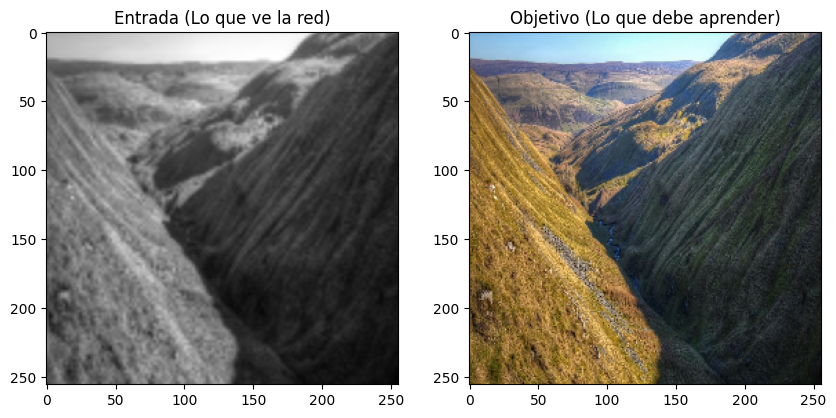

In [ ]:
# Usamos 4000 imágenes para que el tiempo de entrenamiento sea manejable
train_files, val_files = train_test_split(image_paths[:4000], test_size=0.15, random_state=42)

train_ds = tf_data_generator(train_files, BATCH_SIZE)
val_ds = tf_data_generator(val_files, BATCH_SIZE)

# Verificación visual rápida
temp_x, temp_y = next(iter(train_ds))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("Entrada (Lo que ve la red)"); plt.imshow(temp_x[0][:,:,0], cmap='gray')
plt.subplot(1, 2, 2); plt.title("Objetivo (Lo que debe aprender)"); plt.imshow(temp_y[0])
plt.show()

In [ ]:
def build_restoration_unet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    # --- ENCODER ---
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # --- BOTTLENECK ---
    b = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(b)

    # --- DECODER ---
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)

    # --- SALIDA ---
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c6)

    return models.Model(inputs, outputs, name="Restoration_UNet")

model = build_restoration_unet()
model.summary()

Model: "Restoration_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │    131,200 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose

 Total params: 6,921,731 (26.40 MB)

 Trainable params: 6,921,731 (26.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from google.colab import drive

# 1. OPTIMIZACIÓN DE VELOCIDAD
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# 2. MONTAR GOOGLE DRIVE
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Modelos_IA'
os.makedirs(save_path, exist_ok=True)
model_filename = os.path.join(save_path, 'modelo_restauracion_final.keras')

# 3. CALLBACKS
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=model_filename,
    monitor='val_loss',
    save_best_only=True, # Guarda solo si mejora el récord
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# 4. COMPILAR Y ENTRENAR
# Recompilamos para asegurar que use mixed_precision
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

print(f"Iniciando entrenamiento de {EPOCHS} épocas...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr, checkpoint, early_stop]
)

print(f"Entrenamiento finalizado Modelo")

Mounted at /content/drive
Iniciando entrenamiento de 45 épocas...
Epoch 1/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3587 - loss: 0.1438
Epoch 1: val_loss improved from inf to 0.07966, saving model to /content/drive/MyDrive/Modelos_IA/modelo_restauracion_final.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.3587 - loss: 0.1434 - val_accuracy: 0.4184 - val_loss: 0.0797 - learning_rate: 0.0010
Epoch 2/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4166 - loss: 0.0809
Epoch 2: val_loss improved from 0.07966 to 0.07691, saving model to /content/drive/MyDrive/Modelos_IA/modelo_restauracion_final.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.4168 - loss: 0.0809 - val_accuracy: 0.3910 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 3/45
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4679 - loss: 0.0774
Epoch 3: val_loss did not improve from 0.07691
107/107 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4680 - loss: 0.0774 - val_ac

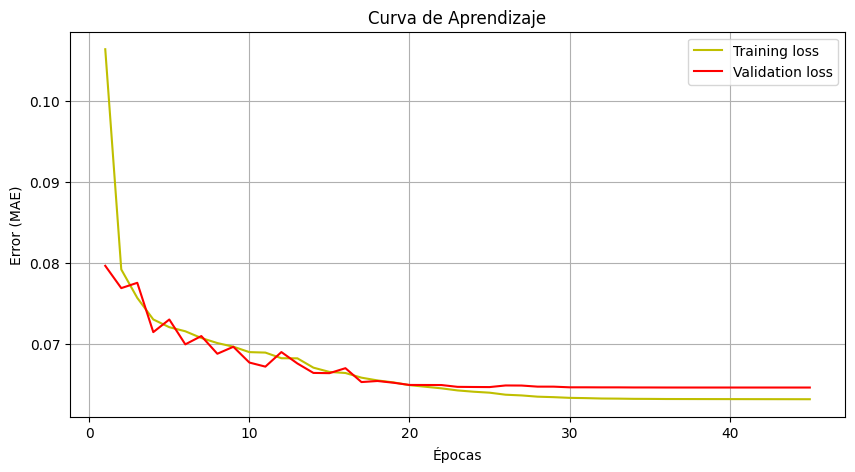

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


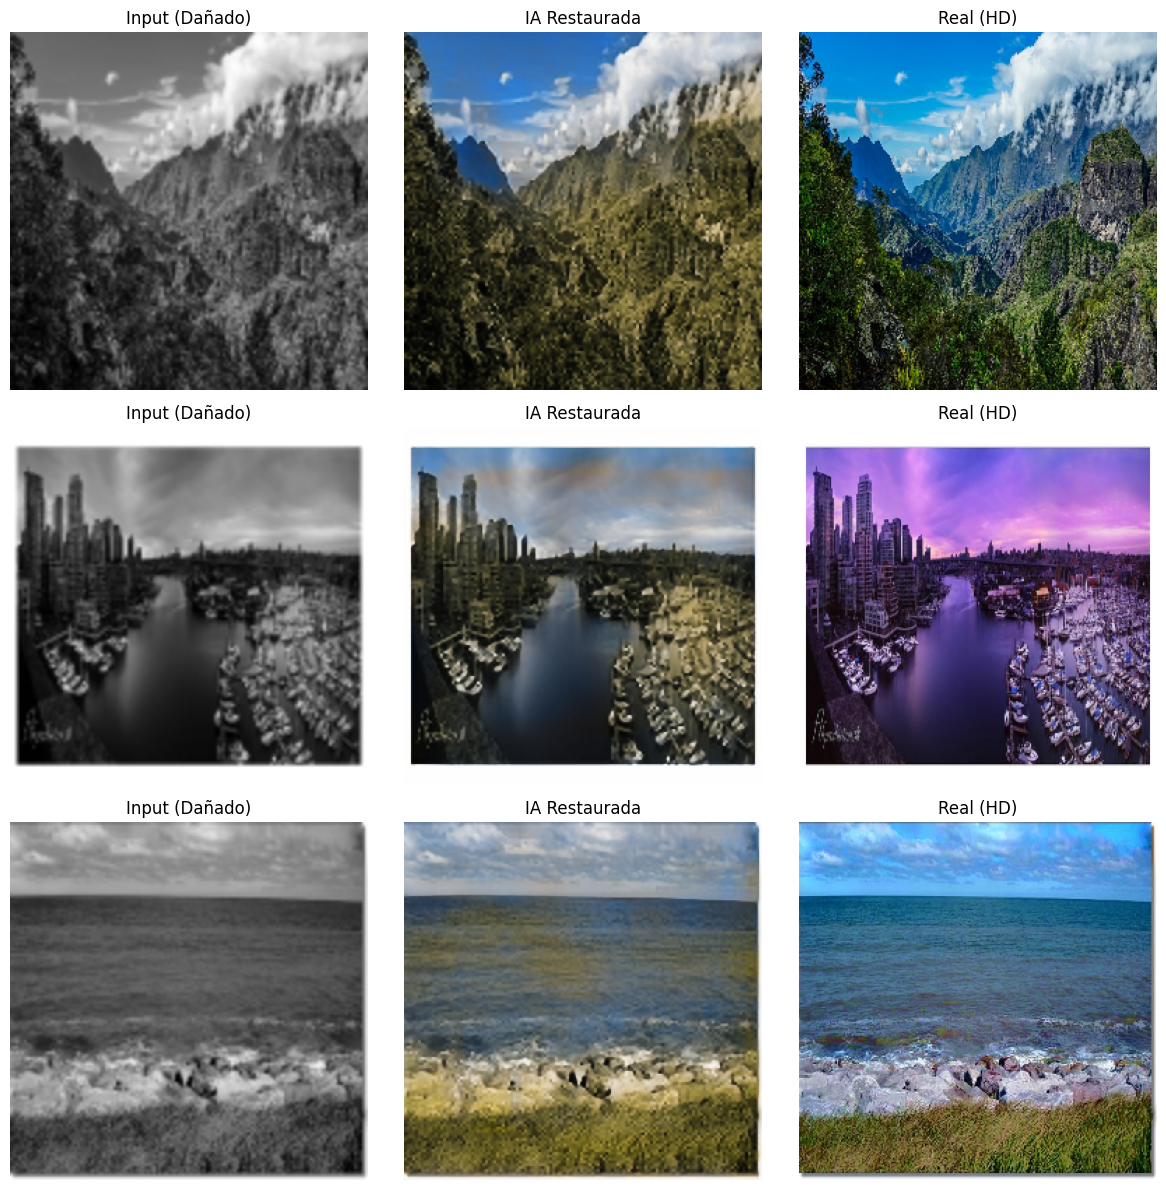

In [ ]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Curva de Aprendizaje')
    plt.xlabel('Épocas')
    plt.ylabel('Error (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_results(model, dataset, num_samples=3):
    x_batch, y_batch = next(iter(dataset))
    y_pred = model.predict(x_batch)

    plt.figure(figsize=(12, 4 * num_samples))
    for i in range(num_samples):
        # Input
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.title("Input (Dañado)")
        plt.imshow(x_batch[i][:,:,0], cmap='gray'); plt.axis('off')
        # Predicción
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.title("IA Restaurada")
        plt.imshow(y_pred[i]); plt.axis('off')
        # Real
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.title("Real (HD)")
        plt.imshow(y_batch[i]); plt.axis('off')
    plt.tight_layout(); plt.show()

plot_history(history)
plot_results(model, val_ds)